In [1]:
import astropy.units as un
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck18
from astropy.io import fits
from astropy.stats import median_absolute_deviation as mad
from astropy.units import Quantity
from astropy.wcs import WCS
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def get_lims(wcs: WCS = None, radius: Quantity = None, center_coord: SkyCoord = None):
    if isinstance(radius, Quantity):
        if radius.isscalar:
            radius_x = radius_y = radius
        else:
            radius_x = radius[0]
            radius_y = radius[1]

    else:
        if isinstance(radius, list):
            radius_x = radius[0] * un.deg
            radius_y = radius[1] * un.deg
        else:
            radius_x = radius_y = radius * un.deg

    left_corner = SkyCoord(ra=center_coord.ra - radius_x, dec=center_coord.dec - radius_y)
    right_corner = SkyCoord(ra=center_coord.ra + radius_x, dec=center_coord.dec + radius_y)
    left, up = left_corner.to_pixel(wcs, origin=0)
    right, down = right_corner.to_pixel(wcs, origin=0)
    xlim = [int(right), int(left)]
    ylim = [int(up), int(down)]
    return xlim, ylim

In [3]:
rm_hdu = fits.open(
    "/home/miguel/Documents/datasets/A1314_JVLA/mfs/non_corrected/max_faraday_depth.fits"
)[0]
p_hdu = fits.open(
    "/home/miguel/Documents/datasets/A1314_JVLA/mfs/non_corrected/max_rotated_intensity.fits"
)[0]
sigma_qu_hdu = fits.open(
    "/home/miguel/Documents/datasets/A1314_JVLA/mfs/non_corrected/sigma_phi_faraday.fits"
)[0]
sigma_phi_hdu = fits.open(
    "/home/miguel/Documents/datasets/A1314_JVLA/mfs/non_corrected/sigma_phi_peak.fits"
)[0]

In [4]:
cluster_center_coord = SkyCoord(ra=173.714 * un.deg, dec=49.091 * un.deg, frame="fk5")

In [5]:
#center_coord = SkyCoord(ra=173.705 * un.deg,dec=49.077 *un.deg, frame="fk5") # Center Source 10
#center_coord = SkyCoord(ra=173.479 * un.deg,dec=49.064 *un.deg, frame="fk5") # C-W Source 3
#center_coord = SkyCoord(ra=173.654 * un.deg, dec=48.978 * un.deg, frame="fk5")  # C-S Extended 9
#center_coord = SkyCoord(ra=173.453 * un.deg,dec=48.985 *un.deg, frame="fk5") # S-W Source 1
#center_coord = SkyCoord(ra=173.803 * un.deg,dec=48.966 *un.deg, frame="fk5") # S-E Source 13

In [6]:
# Centers based on core centers
#center_coord = SkyCoord(ra=173.705 * un.deg,dec=49.077 *un.deg, frame="fk5") # Center Source 10*
#center_coord = SkyCoord(ra=173.496 * un.deg,dec=49.062 *un.deg, frame="fk5") # C-W Source 3*
#center_coord = SkyCoord(ra=173.693 * un.deg,dec=48.956 *un.deg, frame="fk5") # C-S Extended 9*
#center_coord = SkyCoord(ra=173.453 * un.deg,dec=48.985 *un.deg, frame="fk5") # S-W Source 1 *
#center_coord = SkyCoord(ra=173.803 * un.deg,dec=48.966 *un.deg, frame="fk5") # S-E Source 13*
#center_coord = SkyCoord(ra=173.521 * un.deg,dec=49.106 *un.deg, frame="fk5") # 5*
#center_coord = SkyCoord(ra=173.762 * un.deg,dec=49.193 *un.deg, frame="fk5") # 12*
center_coord = SkyCoord(ra=173.943 * un.deg, dec=48.921 * un.deg, frame="fk5")  # 15*

In [7]:
dist_to_center = center_coord.separation(cluster_center_coord)

In [8]:
dist_to_center.arcsec * un.arcsec

<Quantity 816.69849618 arcsec>

In [9]:
redshift_z = 0.034  # X-Ray Center
#redshift_z = 0.033 # Center Source
#redshift_z = 0.032 # C-W Source
#redshift_z = 0.032 # C-S Extended

In [10]:
dist = Planck18.comoving_distance(redshift_z)
scale = Planck18.arcsec_per_kpc_comoving(redshift_z)

In [11]:
dist_kpc = dist_to_center.arcsecond * un.arcsec / scale

In [12]:
dist_kpc

<Quantity 591.72751038 kpc>

In [13]:
wcs = WCS(rm_hdu.header, naxis=2)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [14]:
rm = rm_hdu.data
p = p_hdu.data
sigma_qu = sigma_qu_hdu.data
sigma_phi = sigma_phi_hdu.data

In [15]:
rm = np.where(p > 6 * sigma_qu, rm, np.nan)
sigma_phi = np.where(p > 6 * sigma_qu, sigma_phi, np.nan)
sigma_qu = np.where(p > 6 * sigma_qu, sigma_qu, np.nan)

In [16]:
x_lim, y_lim = get_lims(wcs, radius=0.01 * un.deg, center_coord=center_coord)

In [17]:
rm = rm[y_lim[0]:y_lim[1], x_lim[0]:x_lim[1]]
sigma_phi = sigma_phi[y_lim[0]:y_lim[1], x_lim[0]:x_lim[1]]
p = p[y_lim[0]:y_lim[1], x_lim[0]:x_lim[1]]
sigma_qu = sigma_qu[y_lim[0]:y_lim[1], x_lim[0]:x_lim[1]]

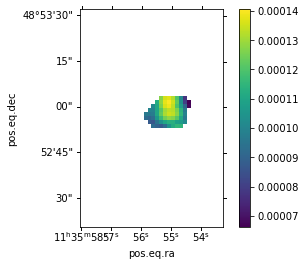

In [18]:
fig = plt.figure()
ax = plt.subplot(projection=wcs)
im = ax.imshow(p)
#ax.set_xlim(x_lim[1], x_lim[0])
#ax.set_ylim(y_lim[1], y_lim[0])
fig.colorbar(im, ax=ax, orientation='vertical')

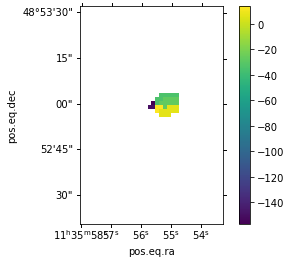

In [19]:
fig = plt.figure()
ax = plt.subplot(projection=wcs)
im = ax.imshow(rm)
#ax.set_xlim(x_lim[1], x_lim[0])
#ax.set_ylim(y_lim[1], y_lim[0])
fig.colorbar(im, ax=ax, orientation='vertical')

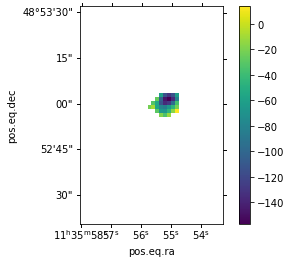

In [20]:
fig = plt.figure()
ax = plt.subplot(projection=wcs)
ax.imshow(sigma_phi)
#ax.set_xlim(x_lim[1], x_lim[0])
#ax.set_ylim(y_lim[1], y_lim[0])
fig.colorbar(im, ax=ax, orientation='vertical')

In [21]:
rm[~np.isnan(rm)]

array([   6.82490692,    6.82490692,    6.82490692,   13.64981384,
          6.82490692,    6.82490692,    6.82490692,    6.82490692,
          6.82490692, -150.1479522 , -150.1479522 ,   13.64981384,
         13.64981384,  -27.29962767,    6.82490692,    6.82490692,
          6.82490692, -156.97285912,  -34.12453459,  -27.29962767,
        -27.29962767,  -27.29962767,  -27.29962767,  -27.29962767,
        -34.12453459,  -34.12453459,  -27.29962767,  -27.29962767,
        -27.29962767,  -27.29962767,  -34.12453459,  -34.12453459,
        -34.12453459,  -34.12453459,  -34.12453459])

In [22]:
sigma_phi[~np.isnan(sigma_phi)]

array([4.3273325, 4.2324505, 4.364363 , 4.263907 , 4.048483 , 4.0347276,
       4.166223 , 4.3400474, 4.5213757, 4.3062716, 4.380904 , 4.0982175,
       3.9679685, 3.9372265, 4.051027 , 4.1657043, 4.3152823, 4.246804 ,
       4.1097426, 3.765434 , 3.616559 , 3.6641583, 3.8561819, 4.21942  ,
       4.2801247, 3.8217652, 3.554763 , 3.49302  , 3.6181314, 3.9418492,
       4.078112 , 3.7561407, 3.6554673, 3.7512271, 4.0707273],
      dtype=float32)

In [23]:
dx = rm_hdu.header["CDELT1"] * un.deg
dy = rm_hdu.header["CDELT2"] * un.deg

In [24]:
npixels = np.count_nonzero(~np.isnan(rm))

In [25]:
bmaj = 12.381457328796387 * un.arcsec
bmin = 11.684733390808105 * un.arcsec
area_pixels = np.pi * bmaj.to(un.deg) * bmin.to(un.deg) / (4. * np.log(2)) / (-dx * dy)
nbeams = npixels / area_pixels

In [26]:
sigma_phi.shape

(55, 36)

In [27]:
pos_max = np.unravel_index(np.nanargmax(p), shape=p.shape)
max_rm = rm[pos_max]
sigma_phi_at_max = sigma_phi[pos_max]
avg_rm = np.nanmean(rm)
med_rm = np.nanmedian(rm)
mad_rm = np.nanmedian(np.abs(rm - np.nanmedian(rm)))
sigma_rm_obs = np.nanstd(rm)
med_sigma_phi = np.nanmedian(sigma_phi)
sigma_rm = np.sqrt(sigma_rm_obs**2 - med_sigma_phi**2)

In [28]:
mean_error = sigma_rm_obs / np.sqrt(nbeams)
sigma_error = sigma_rm / np.sqrt(nbeams)

In [29]:
print("RM at max(P): {0:.1f}".format(max_rm))
print("sigma phi at max(P): {0:.1f}".format(sigma_phi_at_max))
print("<RM> : {0:.1f}".format(avg_rm))
print("sigma(RM): {0:.1f}".format(sigma_rm))
print("med(RM): {0:.1f}".format(med_rm))
print("MAD(RM): {0:.1f}".format(mad_rm))
print("med(sigma_phi): {0:.1f}".format(med_sigma_phi))
print("nbeams: {0:.1f}".format(nbeams))
print("sigma(RM)_obs: {0: .1f}".format(sigma_rm_obs))
print("mean error: {0: .1f}".format(mean_error))
print("sigma error: {0: .1f}".format(sigma_error))

RM at max(P): -27.3
sigma phi at max(P): 3.5
<RM> : -25.3
sigma(RM): 42.9
med(RM): -27.3
MAD(RM): 6.8
med(sigma_phi): 4.1
nbeams: 0.4
sigma(RM)_obs:  43.1
mean error:  71.8
sigma error:  71.5


In [30]:
sigma_rm_obs**2

1859.3717814623833

In [31]:
-med_sigma_phi**2

-16.570821144422553

In [32]:
sigma_rm = np.sqrt(sigma_rm_obs**2 - med_sigma_phi**2)